In [51]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [52]:
languages = ['java', 'nodejs', 'go', 'posix', 'arduino_due']
log_modes = ['monitor', 'monitor-bin']
modes = ['no', 'off', 'on']
fig_counter = 0
root='../../../src-gen/logs'

In [53]:
def allFiles(language, mode, log_mode):
    directory = os.fsencode(root + '/' + log_mode + '/' + mode)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.split('-')[1] == language and filename.endswith('.log'): 
            yield root + '/' + log_mode + '/' + mode + '/' + filename
            
def loadMemory(filename, language):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break
        #if language == 'go':
        #    line = line[20:]
        if line.startswith('>usedMem:'):
            mem = int(line[1:].strip().split(':')[1:][0])
            yield mem   
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break                  
        if line.startswith('>done in '):
            time = line[9:-4].strip()
            return int(time)              

In [54]:
def allData(language, mode, log_mode):
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, log_mode):
        mem = np.array(list(loadMemory(filename, language))).astype(int).flatten()
        t = loadTotalTime(filename)
        all_mem.append(mem)
        all_t.append(t)
    return all_mem, all_t

Processing java no monitor...
Processing java off monitor...
Processing java on monitor...


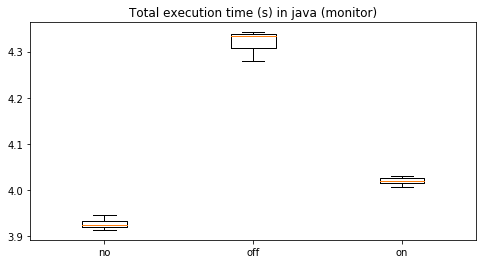

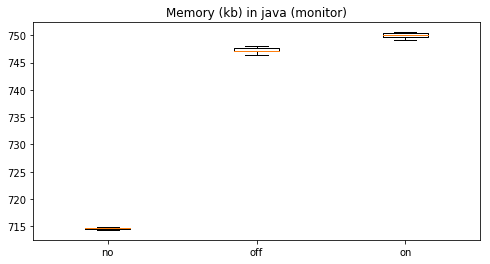

Processing nodejs no monitor...
Processing nodejs off monitor...
Processing nodejs on monitor...


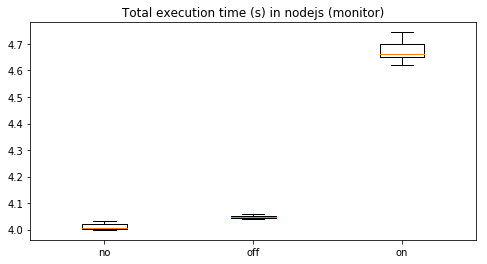

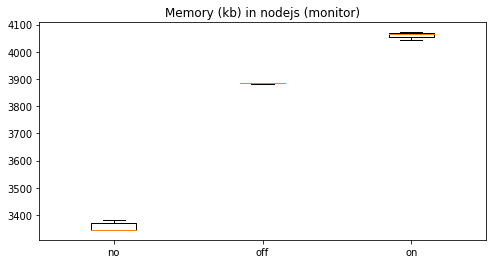

Processing go no monitor...
Processing go off monitor...
Processing go on monitor...


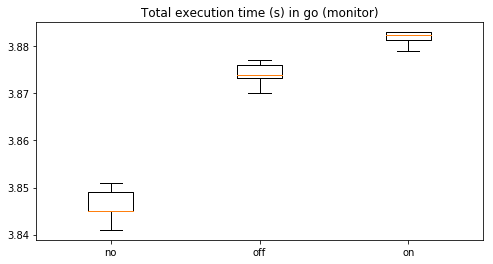

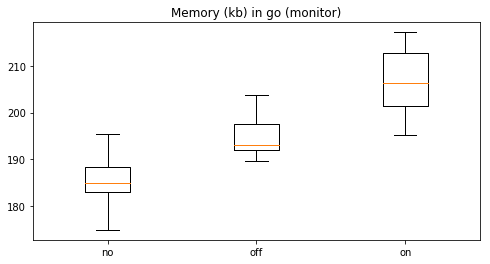

Processing posix no monitor...
Processing posix off monitor...
Processing posix off monitor: Error!
Processing arduino_due no monitor...
Processing arduino_due off monitor...
Processing arduino_due on monitor...


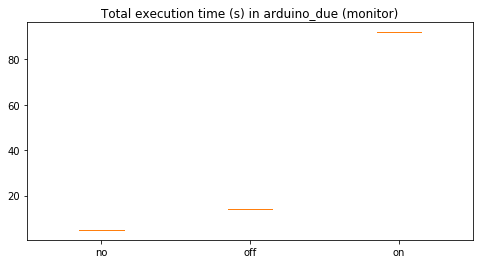

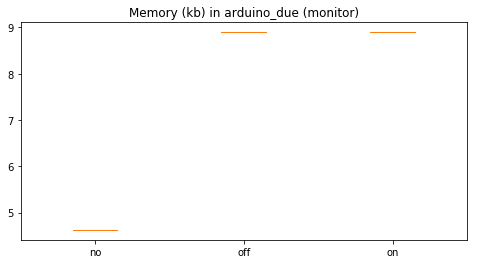

Processing java no monitor-bin...
Processing java off monitor-bin...
Processing java on monitor-bin...


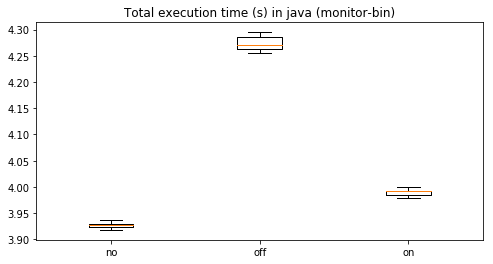

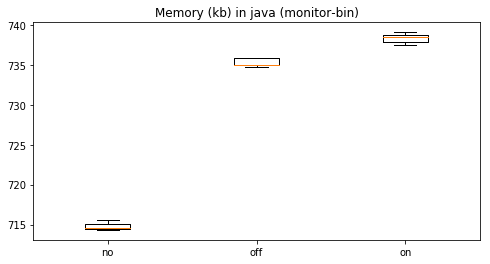

Processing nodejs no monitor-bin...
Processing nodejs off monitor-bin...
Processing nodejs on monitor-bin...


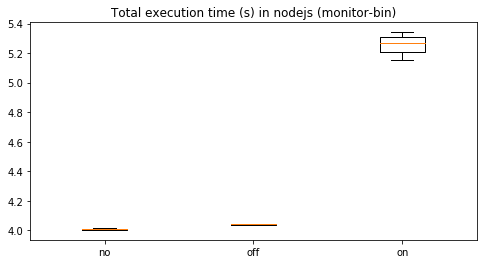

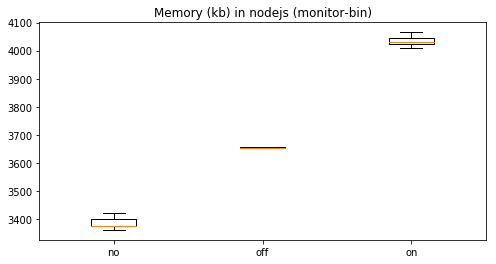

Processing go no monitor-bin...
Processing go off monitor-bin...
Processing go on monitor-bin...


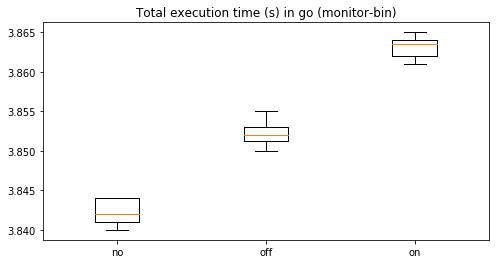

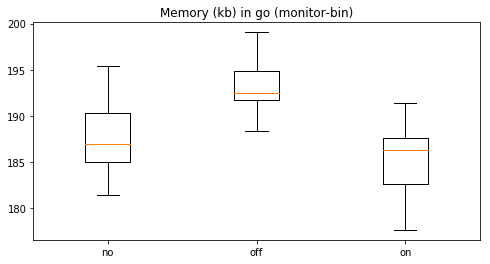

Processing posix no monitor-bin...
Processing posix off monitor-bin...
Processing posix on monitor-bin...


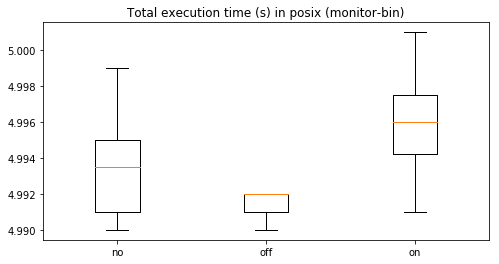

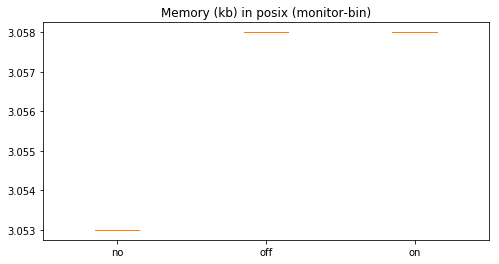

Processing arduino_due no monitor-bin...
Processing arduino_due off monitor-bin...
Processing arduino_due on monitor-bin...


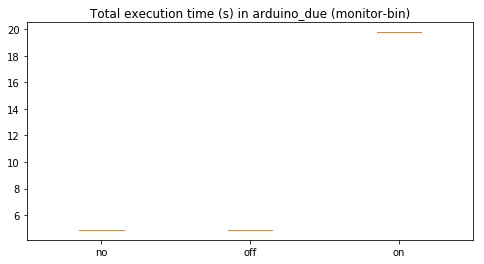

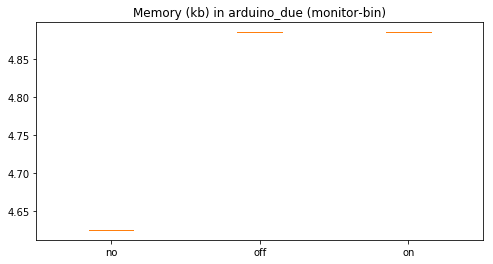

In [55]:
for log_mode in log_modes:
    global fig_counter
    for language in languages:            
        all_t = []
        all_mem = []
        hasError = False
        for mode in modes:
            print('Processing ' + language + ' ' + mode + ' ' + log_mode + '...')
            mem, t = allData(language, mode, log_mode)
            try:
                all_t.append(np.array(t).flatten()/1000)
                all_mem.append(np.array(mem).flatten()/1000)
            except TypeError:
                print('Processing ' + language + ' ' + mode + ' ' + log_mode + ': Error!')
                hasError = True
                break
        
        if hasError:
            continue
            
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_t, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Total execution time (s) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_mem, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Memory (kb) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    